### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Image enhancement algorithms in the spatial domain**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction


#### Spatial filtering

Filtering refers to passing, modifying, or rejecting specified frecuency components of an image.

Spatial filtering modifies an image by replacing the value of each pixel by a function of the values of the pixel and its neighbors.


#### Spatial correlation and convolution

**Spatial correlation** consist of moving the center of a kernel over an image and computing the sum of products at each location.

<img src="./data/linear_spatial_filtering.png" alt="Linear spatial filtering" width="200"/>

*where:*
* *f* : image of size *M* x *N*
* *w*: kernel , filter of size *m* x *n*
* (*x*, *y*): any point in the image
* *g*(*x*. *y*): the output
* s is the row index relative to the kernel's center (e.g., −1,0,1 for a 3×3 kernel).
* t is the column index relative to the kernel's center (e.g., −1,0,1 for a 3×3 kernel).


Correlation is a function of *displacement of the filter kernel relative to the image*



**Spatial convolution** is the same, except that the correlation kernel is rotated by 180º.


#### Padding
Kernel of size *m* x *n* we pad the image with a minimum of (m-1)/2 rows of 0's at the top and bottom and (n-1)/2 columns of 0's on the left and right



#### Kernel dimensions

<img src="https://miro.medium.com/v2/resize:fit:1052/0*Asw1tDuRs3wTjwi7.gif" alt="Linear spatial filtering" width="200"/>

in correlation and convolution every element of *w* visits every pixel in *f*

This requires of two configurations, the *starting configuration* and the *ending configuration*

the starting configuration be such that the right, lower corner of the kernel coincides with the origin of the image.

the ending configuration will be the top left corner of the kernel coinciding with the lower right corner of the image.


#### Edge Detection


With Edge Detection algorithms such as prewitt, sobel and laplaciano, are essential for image segmentation.

Edge detection involves the use of filters (P.E, n x n) kernel matrices to mask irrelevant data and keep image edges. the kernel size influences the image's sharpness

* 2x2 or 3x3 yielding sharp edges
* 5*5 producing blurred edges


Example of a matrix multiplication of image pixes with a kernel of 3 x 3 
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*2U8rAjJ9r22WPNM75SbFxg.png" alt="Edge Detection Using Prewitt Algorithm" width="500"/>


### Edge detection types

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*mHO2ERxjSGTMLBgLVrCUHg.png" alt="Edge detection types" width="500"/>

#### Gradient Based
d
#### Gaussian Based


716





### Importing libraries

In [2]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

### Loading Images

In [3]:
# Loading images
moon = Image.open("data/moon.jpg")
fingerprint = Image.open("data/fingerprint.png")
plans = Image.open("data/plans.jpg")
dragon = Image.open("data/dragon.png")

In [4]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    plot a set of images
    """
    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if len(labels) > 0:
                ax.set_title(labels[i])
            # dont show the axis ticks 
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots 
    plt.tight_layout()
    plt.show()

### 1. Line Detectors

#### 1.1 Prewitt


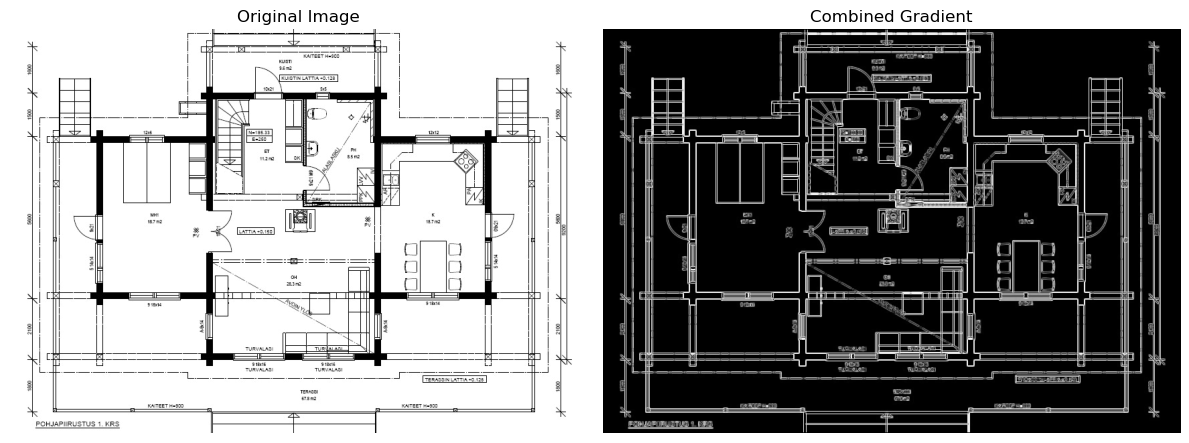

In [6]:
def prewitt(image):
    # normalizie the image
    image = np.array(image, dtype=np.float32) / 255.0

    # Prewitt kernels
    # getting Gx
    prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    # getting Gy
    prewitt_y = np.array([[-1, -1, -1], [ 0,  0,  0], [ 1,  1,  1]])

    # Get height and widht of the image
    height = image.shape[0]
    width = image.shape[1]

    # Initialize array for edges
    edges_x = np.zeros((height, width))
    edges_y = np.zeros((height, width))

    # Applying Prewitt method
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Executes n*n = n^2 times O(n^2)
            region = image[i-1:i+2, j-1:j+2]
            x_result = np.sum(region * prewitt_x)
            y_result = np.sum(region * prewitt_y)

            edges_x[i, j] = x_result
            edges_y[i, j] = y_result

    edges_combined = np.sqrt(edges_x**2 + edges_y**2)
    return edges_combined

# converting the imageinto gray scale
gray = plans.convert("L")
result = prewitt(gray)
plot_images(images=[gray, result], labels=["Original Image", "Combined Gradient"])


**Algorithmic Complexity**

The algorithmic complexity of this method is O(n), as the image is traversed pixel by pixel in this method.


**Reference**

https://www.geeksforgeeks.org/edge-detection-using-prewitt-scharr-and-sobel-operator/

#### 1.2 Sobel

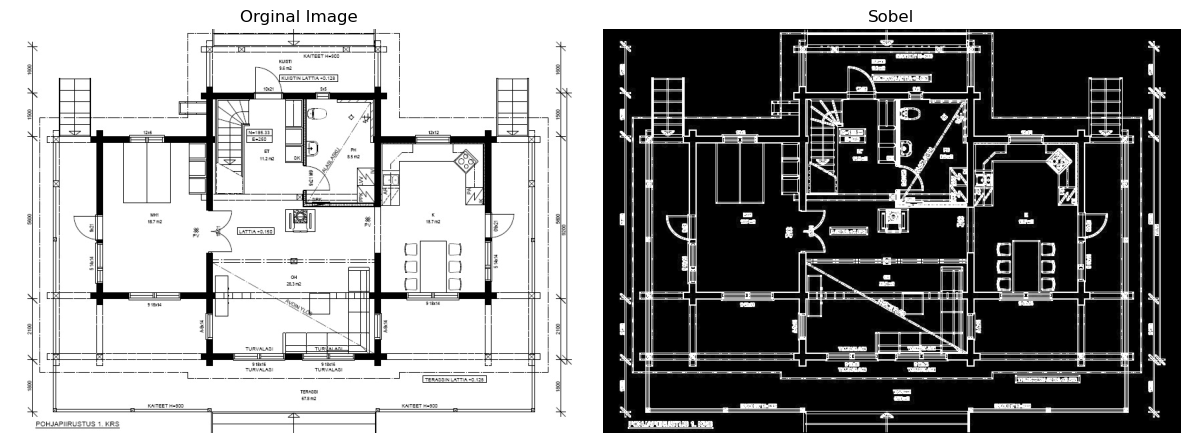

In [8]:
def sobel(image):
    # normalizie the image
    image = np.array(image, dtype=np.float32) / 255.0

    # define Sobel filters
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Get height and widht of the image
    height = image.shape[0]
    width = image.shape[1]


    # Initialize empty array for edges
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)

    # Appliying Sobel method
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Executes n*n = n^2 times O(n^2)
            region = image[i - 1:i + 2, j - 1:j + 2]
            gradient_x[i, j] = np.sum(region * sobel_x)
            gradient_y[i, j] = np.sum(region * sobel_y)

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    # normalizie the magnitud
    gradient_magnitude = np.clip(gradient_magnitude, 0, 1)
    
    return gradient_magnitude

# Convert image into gray
plans = plans.convert("L")
result = sobel(plans)
plot_images(images=[plans, result], labels=["Orginal Image", "Sobel"])

**Algorithmic Complexity**

The algorithmic complexity of this method is O(n), as the image is traversed pixel by pixel in this method.

**Reference:**

https://medium.com/@haidarlina4/sobel-vs-canny-edge-detection-techniques-step-by-step-implementation-11ae6103a56a


#### 1.3 Laplaciano

*Explain which algorithm is more efficient*

### 2. Image enhancement algorithms
Implement an image enhancement or enhancement algorithm through an algorithm in which the lines are extracted from the image and then the difference with the original image is applied, multiplying the pixels of the “mask” image (the lines found) by a alpha factor greater than 1.




### 3. A Case Study in Medical Imaging (PET images)

### Conclusion

*Team conclusion*

### References

K, H. (2024, February 29). Image Preprocessing with Computer Vision: Edge Detection Using Prewitt Algorithm. Medium. https://medium.com/@hassanjadoon2001/image-preprocessing-with-computer-vision-edge-detection-using-prewitt-algorithm-d4f00a2f1565